In [ ]:
# from google.colab import drive
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from keras.layers import *
from keras.models import *
from sklearn.preprocessing import MinMaxScaler
import pickle
from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/MyDrive/Traffic_data'

In [ ]:
#  import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seed = 1024
# nrows = 150159
nrows = 4000
feature_names = ['ego_x',"ego_v", 'f_dx', 'f_dy', 'f_dv', 'b_dx', 'b_dy','b_dv', 'l_dx', 'l_dy', 'l_dv', 'r_dx', 'r_dy', 'r_dv']
label_names_1 = ["ego_v"]
label_names_2 = ['ego_x']
# label_name = 'ego_v'
time_columns = "index"

full_path = Path+'/Final_result.xlsx' 


train_rows=int(nrows*0.8) 
train_model =True  
load_model = False 

learning_rate = 0.001

batch_size = 1 # batch_size
require_improvement_epoch = 5 
num_epochs = 100 
ealry_stop = True

hidden_dim = 100 
target_dim = 1 
num_heads = 4

n_in = 10 
n_out = 5

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from sklearn.preprocessing import MinMaxScaler
import h5py
df = pd.read_excel(full_path,parse_dates=[time_columns],nrows=nrows)
df = df.sort_values(time_columns)
df.index = np.arange(df.shape[0])

In [ ]:
df2=df.iloc[:5000,:]

In [ ]:
df2

index      ego_x      ego_v       f_dx        f_dy      f_dv      b_dx  \
0         0  51.816071  34.006429  30.000000  300.000000  0.000000  0.561490   
1         1  52.726857  35.324286  30.000000  300.000000  0.000000 -1.311634   
2         2  53.001810  37.491429  30.000000  300.000000  0.000000 -2.030706   
3         3  56.291381  39.865238  30.000000  300.000000  0.000000 -5.374435   
4         4  29.079835  33.970674  30.000000  300.000000  0.000000  1.012832   
...     ...        ...        ...        ...         ...       ...       ...   
3995   3995  42.137802  35.090304  -0.221069   -0.221069 -6.712233  0.636319   
3996   3996  42.308804  34.116095  -0.588101   -0.588101 -6.216717  0.579364   
3997   3997  42.443980  32.614500  -1.003208   -1.003208 -4.905719  0.499540   
3998   3998  42.514493  30.974881  -1.423989   -1.423989 -3.315690  0.440175   
3999   3999  42.496366  29.655178  -1.721845   -1.721845 -2.156586  0.477524   

          b_dy      b_dv       l_dx       l_dy      l_dv       r_dx  \
0     0.561490  2.236814 -13.171722 -13.171722  0.154693  30.000000   
1    -1.311634 -0.999323 -13.838332 -13.838332 -0.283392  30.000000   
2    -2.030706 -4.150722 -13.980892 -13.980892 -2.208976  30.000000   
3    -5.374435 -6.864538 -17.218590 -17.218590 -4.814726  30.000000   
4     1.012832  2.269220 -10.292661 -10.292661  4.718274   9.564515   
...        ...       ...        ...        ...       ...        ...   
3995  0.636319  2.623670  -9.622777  -9.622777 -5.764678  10.232875   
3996  0.579364  3.112242  -9.612632  -9.612632 -4.431115  10.159946   
3997  0.499540  3.930849  -9.528238  -9.528238 -2.936426  10.095887   
3998  0.440175  4.465308  -9.353846  -9.353846 -1.775935  10.111250   
3999  0.477524  4.789912  -9.064167  -9.064167 -1.251120  10.198793   

            r_dy      r_dv  
0     300.000000  0.000000  
1     300.000000  0.000000  
2     300.000000  0.000000  
3     300.000000  0.000000  
4       9.564515  0.190448  
...          ...       ...  
3995   10.232875 -3.073664  
3996   10.159946 -0.514571  
3997   10.095887  2.388405  
3998   10.111250  5.294472  
3999   10.198793  7.206028  

[4000 rows x 15 columns]

In [ ]:
scaler_y_1 = MinMaxScaler(feature_range=(-1, 1))
scaler_y_1.fit(df2[label_names_1].astype(float))

scaler_y_2 = MinMaxScaler(feature_range=(-1, 1))
scaler_y_2.fit(df2[label_names_2].astype(float))

scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_x.fit(df2[feature_names].astype(float))

MinMaxScaler(feature_range=(-1, 1))

# **Multi-step Testing**


In [ ]:
def create_dataset(df,feature_names,label_names_1,abel_names_2,n_in,n_out,scaler_x=None,scaler_y_1 = None,scaler_y_2 = None):
  X, Y1, Y2 = [], [], []
  for i in tqdm(range(df.shape[0]-n_in-n_out+1)):
    # x_train.append(np.array(df[feature_names].iloc[i:i+n_in]))
    x = df[feature_names].values[i:i+n_in].astype(float)
    x = scaler_x.transform(x)
    # print(x)
    label1 = df[label_names_1].values[i+n_in:i+n_in+n_out].astype(float)
    label1 = scaler_y_1.transform(label1)
    label2 = df[label_names_2].values[i+n_in:i+n_in+n_out].astype(float)
    label2 = scaler_y_2.transform(label2)
    # label = scaler_y.transform(label.reshape(-1,1)).reshape(-1)
    X.append(x)
    Y1.append(label1)
    Y2.append(label2)

    # break
  return np.array(X),np.array(Y1),np.array(Y2)

In [ ]:
X_1,Y1,Y2 = create_dataset(df2,feature_names,label_names_1,label_names_2,10,5,scaler_x,scaler_y_1,scaler_y_2)

  0%|          | 0/3986 [00:00<?, ?it/s]C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feat

In [ ]:
x1_train, x1_test = X_1[:train_rows], X_1[train_rows:]
y1_train, y1_test = Y1[:train_rows], Y1[train_rows:]
y2_train, y2_test = Y2[:train_rows], Y2[train_rows:]
print(x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape,y2_train.shape,y2_test.shape)

(3200, 10, 14) (786, 10, 14) (3200, 5, 1) (786, 5, 1) (3200, 5, 1) (786, 5, 1)


In [ ]:
# out=5,y1 lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = False,
                   input_shape = (x1_train.shape[1], x1_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=5))
# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=20
batch_size_RNN=64
model=regressor.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Epoch 1/20
50/50 [==============================] - 7s 8ms/step - loss: 0.0564
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0343
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0256
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 9/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 10/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 11/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 12/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 13/20
50/50 [==============================

In [ ]:
# out=5,y1 stracked lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
y1_train=y1_train.reshape((y1_train.shape[0],y1_train.shape[1]))
# Initialising the RNN
regressor2 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor2.add(LSTM(units = layer_1_units, return_sequences = True,
                   input_shape = (x1_train.shape[1], x1_train.shape[2])))
regressor2.add(LSTM(20, activation='relu'))
regressor2.add(Dropout(0.2))
regressor2.add(Dense(units=5))
# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=20
batch_size_RNN=64
model2=regressor2.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/20
50/50 [==============================] - 3s 28ms/step - loss: 0.0522
Epoch 2/20
50/50 [==============================] - 2s 34ms/step - loss: 0.0402
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 0.0337
Epoch 4/20
50/50 [==============================] - 1s 28ms/step - loss: 0.0306
Epoch 5/20
50/50 [==============================] - 2s 34ms/step - loss: 0.0278
Epoch 6/20
50/50 [==============================] - 2s 32ms/step - loss: 0.0250
Epoch 7/20
50/50 [==============================] - 1s 28ms/step - loss: 0.0232
Epoch 8/20
50/50 [==============================] - 1s 29ms/step - loss: 0.0225
Epoch 9/20
50/50 [==============================] - 2s 33ms/step - loss: 0.0212
Epoch 10/20
50/50 [==============================] - 2s 32ms/step - loss: 0.0206
Epoch 11/20
50/50 [==============================] - 1s 30ms/step - loss: 0.0192
Epoch 12/20
50/50 [==============================] - 1s 25ms/step - loss: 0.0192
Epoch 13/20
50/50 [==================

In [ ]:
# out=5,y1 ae-lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector,TimeDistributed
y1_train=y1_train.reshape((y1_train.shape[0],y1_train.shape[1]))
# Initialising the RNN
regressor3 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=100
regressor3.add(LSTM(units = layer_1_units, input_shape = (x1_train.shape[1], x1_train.shape[2])))
regressor3.add(RepeatVector(5))
regressor3.add(LSTM(layer_1_units, activation='relu', return_sequences=True))
regressor3.add(TimeDistributed(Dense(1)))

# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor3.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=20
batch_size_RNN=64
model3=regressor3.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/20
50/50 [==============================] - 2s 16ms/step - loss: 0.0381
Epoch 2/20
50/50 [==============================] - 1s 16ms/step - loss: 0.0242
Epoch 3/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0197
Epoch 4/20
50/50 [==============================] - 1s 17ms/step - loss: 0.0175
Epoch 5/20
50/50 [==============================] - 1s 16ms/step - loss: 0.0155
Epoch 6/20
50/50 [==============================] - 1s 16ms/step - loss: 0.0140
Epoch 7/20
50/50 [==============================] - 1s 15ms/step - loss: 0.0138
Epoch 8/20
50/50 [==============================] - 1s 16ms/step - loss: 0.0124
Epoch 9/20
50/50 [==============================] - 1s 15ms/step - loss: 0.0123
Epoch 10/20
50/50 [==============================] - 1s 15ms/step - loss: 0.0115
Epoch 11/20
50/50 [==============================] - 1s 15ms/step - loss: 0.0113
Epoch 12/20
50/50 [==============================] - 1s 15ms/step - loss: 0.0104
Epoch 13/20
50/50 [==================

In [ ]:
from keras.layers import Layer
import keras.backend as K
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
# out=5,y1 lstm att
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN,LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
epoch_no=20
batch_size_RNN=64
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model  

model_attention = create_RNN_with_attention(hidden_units=100, dense_units=5, 
                                  input_shape=(x1_train.shape[1], x1_train.shape[2]), activation='tanh')
model_attention.summary()   
model_attention.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10, 14)]          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 10, 100)           46000     
_________________________________________________________________
attention_9 (attention)      (None, 100)               110       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 505       
Total params: 46,615
Trainable params: 46,615
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
50/50 [==============================] - 2s 12ms/step - loss: 0.0458
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 3/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0311
Epoch 4/20
50/5

In [ ]:
trainPredict = regressor.predict(x1_train)
trainPredict2 = regressor2.predict(x1_train)
trainPredict3 = regressor3.predict(x1_train)
trainPredict4 = model_attention.predict(x1_train)
# trainPredict4 = regressor4.predict(x1_train)
trainPredict3=trainPredict3.reshape(trainPredict3.shape[0],trainPredict3.shape[1])
y1_train_cnt =  scaler_y_1.inverse_transform(y1_train.reshape(-1, 5))
# y2_train_cnt =  scaler_y_2.inverse_transform(y2_train.reshape(-1, 5))
trainPredict_cnt = scaler_y_1.inverse_transform(trainPredict)
# trainPredict1_cnt = scaler_y_2.inverse_transform(trainPredict1)
trainPredict2_cnt = scaler_y_1.inverse_transform(trainPredict2)
trainPredict3_cnt = scaler_y_1.inverse_transform(trainPredict3)
trainPredict4_cnt = scaler_y_1.inverse_transform(trainPredict4)

In [ ]:
from sklearn.metrics import r2_score
r2=r2_score(y1_train_cnt[:3200,0], trainPredict_cnt[:3200,0])
print(r2)

0.9145913624265389


In [ ]:
r2=r2_score(y1_train_cnt[:3200,0], trainPredict2_cnt[:3200,0])
print(r2)

0.9015874150492306


In [ ]:
r2=r2_score(y1_train_cnt[:3200,0], trainPredict3_cnt[:3200,0])
print(r2)

0.9387245678311055


In [ ]:
r2=r2_score(y1_train_cnt[:3200,0], trainPredict4_cnt[:3200,0])
print(r2)

0.9169015719173893


<function matplotlib.pyplot.show(*args, **kw)>

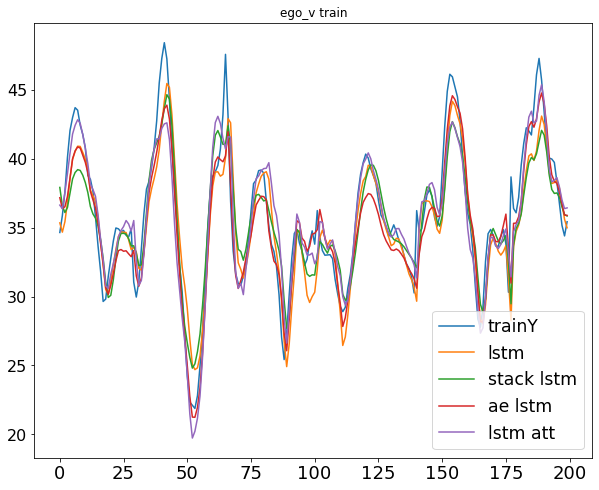

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(y1_train_cnt[:200,0],label='trainY')
# plt.plot(y_train[:200,2],label='trainY')
plt.plot(trainPredict_cnt[:200,0],label='lstm')
plt.plot(trainPredict2_cnt[:200,0],label='stack lstm')
plt.plot(trainPredict3_cnt[:200,0],label='ae lstm')
plt.plot(trainPredict4_cnt[:200,0],label='lstm att')
# plt.plot(trainPredict4_cnt[:200,1],label='out=10 trainpredict')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.title('ego_v train')
plt.show

In [ ]:
x1_train.shape,y1_train.shape,trainPredict3_cnt.shape,trainPredict3.shape,trainPredict2.shape,trainPredict.shape

((3200, 10, 14), (3200, 5), (3200, 5), (3200, 5), (3200, 5), (3200, 5))

In [ ]:
r2_1=r2_score(y1_train_cnt[2200:2220,0], trainPredict_cnt[2200:2220,0])
r2_2=r2_score(y1_train_cnt[2200:2220,0], trainPredict2_cnt[2200:2220,0])
r2_3=r2_score(y1_train_cnt[2200:2220,0], trainPredict3_cnt[2200:2220,0])
r2_4=r2_score(y1_train_cnt[2200:2220,0], trainPredict4_cnt[2200:2220,0])
print(r2_1,r2_2,r2_3,r2_4)

0.5725882097693302 0.5723583715300411 0.7381676123920021 0.6977836371132115


<function matplotlib.pyplot.show(*args, **kw)>

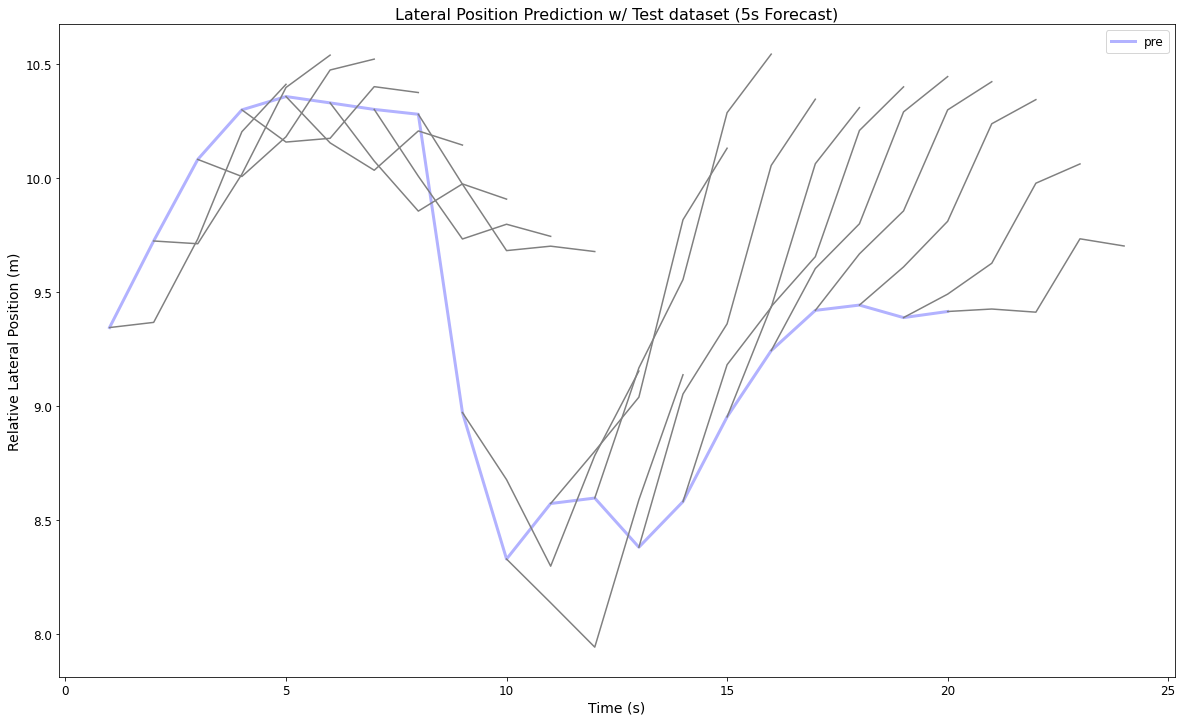

In [ ]:
plt.figure(figsize=(20, 12))  
# plt.plot(range(1,21),y1_train_cnt[2200:2220,0]/3.28084,label='GT')
plt.plot(range(1,21),trainPredict4_cnt[2200:2220,0]/3.28084,'blue',label='pre',linewidth = 3, alpha=0.3)
# plt.plot(range(10,180),testPredict_10_x_act[10200:10370,9]/3.28084,'green',label='Forecast = 10s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2200,2220):
  # plt.plot(y1_test_act[i][:]/3.28084)
  plt.plot(range(m,m+5),trainPredict4_cnt[i][:]/3.28084,'gray')
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

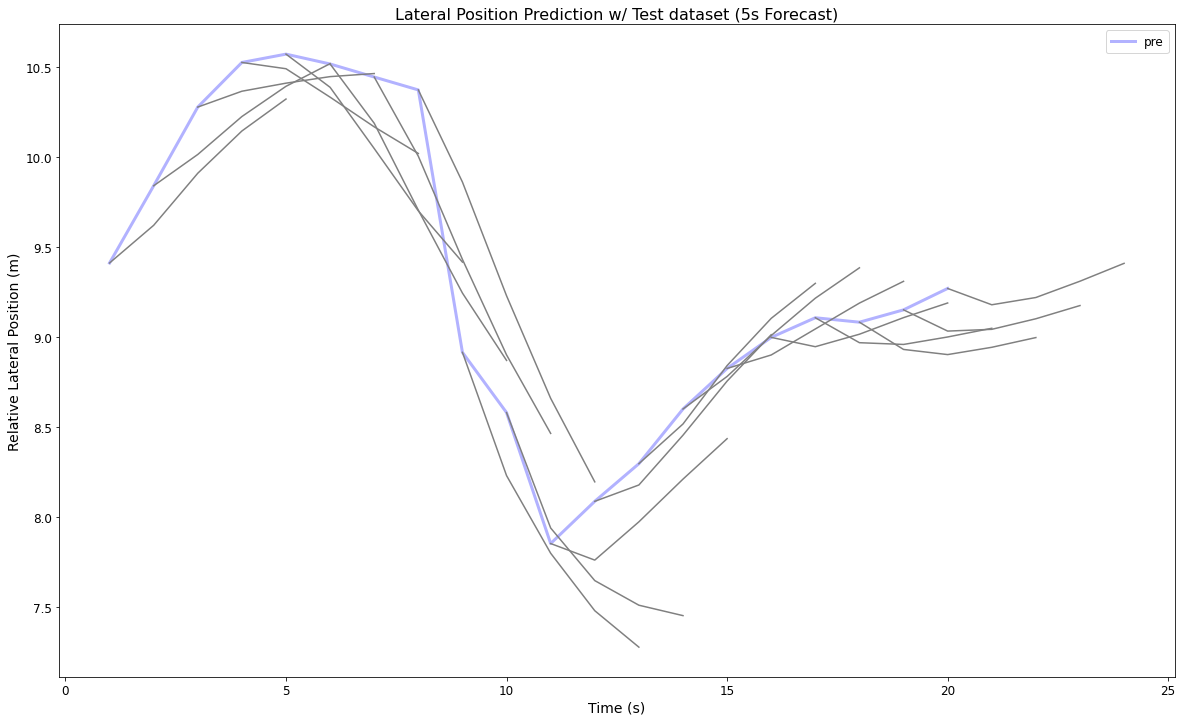

In [ ]:
plt.figure(figsize=(20, 12))  
# plt.plot(range(1,21),y1_train_cnt[2200:2220,0]/3.28084,label='GT')
plt.plot(range(1,21),trainPredict3_cnt[2200:2220,0]/3.28084,'blue',label='pre',linewidth = 3, alpha=0.3)
# plt.plot(range(10,180),testPredict_10_x_act[10200:10370,9]/3.28084,'green',label='Forecast = 10s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2200,2220):
  # plt.plot(y1_test_act[i][:]/3.28084)
  plt.plot(range(m,m+5),trainPredict3_cnt[i][:]/3.28084,'gray')
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

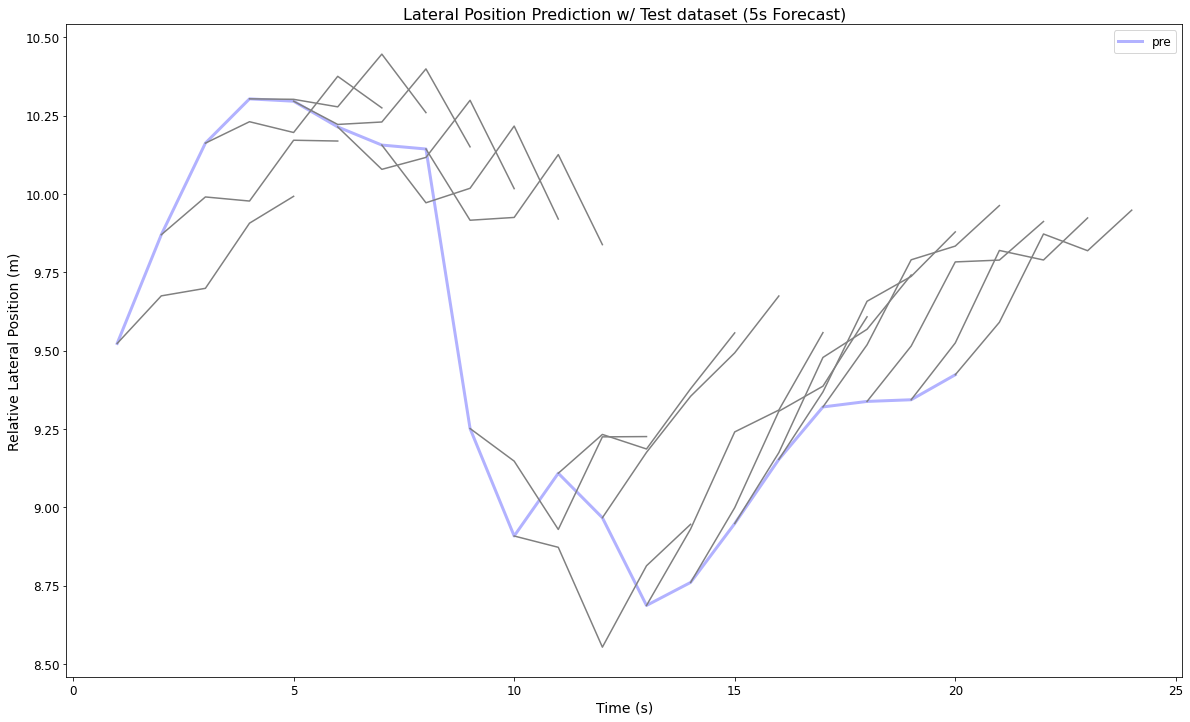

In [ ]:
plt.figure(figsize=(20, 12))  
# plt.plot(range(1,21),y1_train_cnt[2200:2220,0]/3.28084,label='GT')
plt.plot(range(1,21),trainPredict2_cnt[2200:2220,0]/3.28084,'blue',label='pre',linewidth = 3, alpha=0.3)
# plt.plot(range(10,180),testPredict_10_x_act[10200:10370,9]/3.28084,'green',label='Forecast = 10s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2200,2220):
  # plt.plot(y1_test_act[i][:]/3.28084)
  plt.plot(range(m,m+5),trainPredict2_cnt[i][:]/3.28084,'gray')
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

单步递归策略

In [ ]:
def create_dataset_dan(df,feature_names,n_in,n_out,scaler_x=None,scaler_y_1 = None,scaler_y_2 = None):
  X, Y = [], []
  for i in tqdm(range(df.shape[0]-n_in-n_out+1)):
    # x_train.append(np.array(df[feature_names].iloc[i:i+n_in]))
    x = df[feature_names].values[i:i+n_in].astype(float)
    x = scaler_x.transform(x)
    # print(x)
    label = df[feature_names].values[i+n_in:i+n_in+n_out].astype(float)
    label = scaler_x.transform(label)
    # label2 = df[label_names_2].values[i+n_in:i+n_in+n_out].astype(float)
    # label2 = scaler_y_2.transform(label2)
    # label = scaler_y.transform(label.reshape(-1,1)).reshape(-1)
    X.append(x)
    Y.append(label)
   

    # break
  return np.array(X),np.array(Y)

In [ ]:
X_new,Y_new = create_dataset_dan(df2,feature_names,1,1,scaler_x)

  0%|          | 0/3999 [00:00<?, ?it/s]C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\xyang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feat

In [ ]:
x1_train_new, x1_test_new = X_new[:train_rows], X_new[train_rows:]
y1_train_new, y1_test_new = Y_new[:train_rows], Y_new[train_rows:]


In [ ]:
# out=5,y1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor4 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor4.add(LSTM(units = layer_1_units, return_sequences = False,
                   input_shape = (x1_train_new.shape[1], x1_train_new.shape[2])))
regressor4.add(Dropout(0.2))
regressor4.add(Dense(units=14))
# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor4.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=20
batch_size_RNN=64
model4=regressor4.fit(x1_train_new, y1_train_new, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/20
50/50 [==============================] - 1s 6ms/step - loss: 0.3120
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2289
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2177
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2146
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2130
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2123
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2122
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2116
Epoch 9/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2114
Epoch 10/20
50/50 [==============================] - 0s 3ms/step - loss: 0.2111
Epoch 11/20
50/50 [==============================] - 0s 3ms/step - loss: 0.2111
Epoch 12/20
50/50 [==============================] - 0s 4ms/step - loss: 0.2110
Epoch 13/20
50/50 [==============================

In [ ]:
trainPredict4 = regressor4.predict(x1_train_new)
print(trainPredict4.shape)

(3200, 14)


In [ ]:
trainPredict4 = regressor4.predict(x1_train_new)
# trainPredict4 = regressor4.predict(x1_train)
# y1_train_cnt =  scaler_x.inverse_transform(y1_train.reshape(-1, 1))
trainPredict4_cnt = scaler_x.inverse_transform(trainPredict4)

In [ ]:
# out=5,y1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor5 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor5.add(LSTM(units = layer_1_units, return_sequences = False,
                   input_shape = (x1_train_new.shape[1], x1_train_new.shape[2])))
regressor5.add(RepeatVector(1))
regressor5.add(LSTM(50, activation='relu', return_sequences=True))
regressor5.add(TimeDistributed(Dense(14)))
# regressor5.add(Dense(units=14))
# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor5.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=50
batch_size_RNN=64
model5=regressor5.fit(x1_train_new, y1_train_new, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/50
50/50 [==============================] - 2s 9ms/step - loss: 0.3330
Epoch 2/50
50/50 [==============================] - 1s 10ms/step - loss: 0.1238
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0618
Epoch 4/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0468
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0385
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0361
Epoch 7/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0351
Epoch 8/50
50/50 [==============================] - 0s 9ms/step - loss: 0.0344
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0337
Epoch 10/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0331
Epoch 11/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0323
Epoch 12/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0317
Epoch 13/50
50/50 [====================